# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[critics.quote.notnull()]
critics.head()


,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [5]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


In [6]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'

grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic
means.head()


critic
A.D. Murphy     1.000000
A.H. Weiler     0.705882
A.O. Scott      0.368421
Aaron Hillis    1.000000
Abel Green      1.000000
Name: fresh, dtype: float64

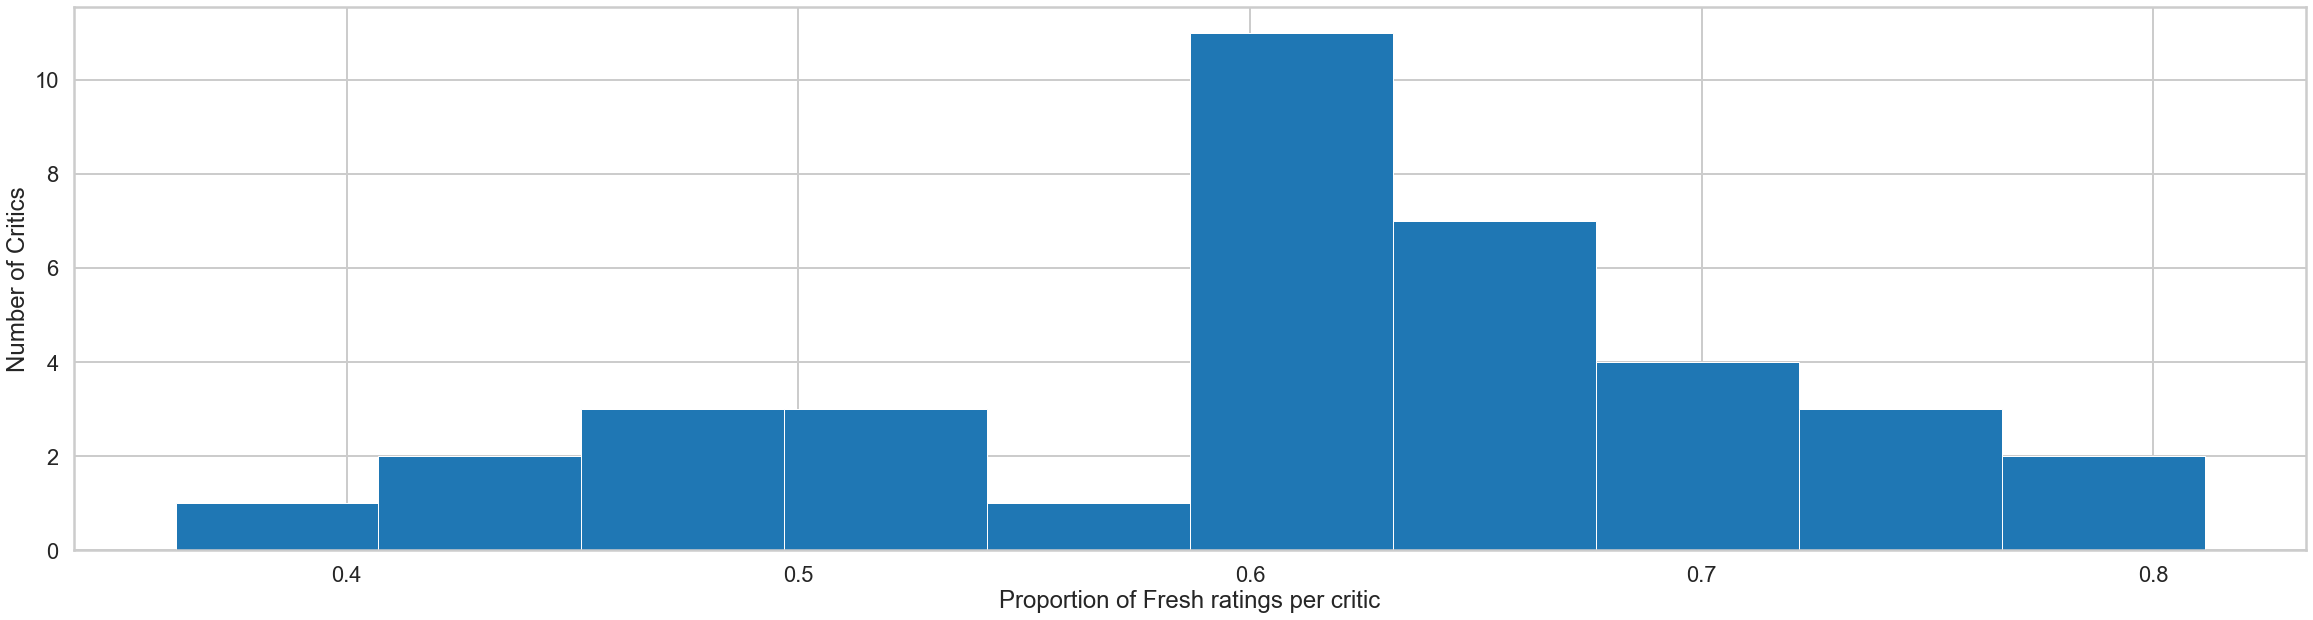

In [123]:
means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Proportion of Fresh ratings per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

Above is displayed the proportion of fresh ratings given by each critic. This proportion ranges from 0.4 to 0.8, centering around 0.6. There are reasonably well balanced classes of fresh and not-fresh. The data appear to be left-tailed, which could be due to the economic incentives towards awarding movies a fresh rating (you don't give free movie passes to people who hate movies!).

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,1,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (29,1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 29:trained, 30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [9]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Simple classifier

Below is a simple multinomial classifier. We use a 20% validation set.

In [47]:
# Import necessary objects
from sklearn.naive_bayes import MultinomialNB 
from sklearn.model_selection import train_test_split
# Split the data (we have defined X and y above)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# Instantiate the classifier
clf = MultinomialNB()

# Training
clf.fit(X_train, y_train)
# Testing
clf.predict(X_test)
# Accuracy scores
test_accuracy = clf.score(X_test, y_test)
train_accuracy = clf.score(X_train, y_train)

print('The training accuracy of the multinomial naive Bayes model was {:.2f}'.format(train_accuracy))
print('The testing accuracy of the multinomial naive Bayes model was {:.2f}'.format(test_accuracy))

The training accuracy of the multinomial naive Bayes model was 0.92
The testing accuracy of the multinomial naive Bayes model was 0.78


The multinomial model returned a testing accuracy of 0.78, somewhat better than a strategy of guessing 'fresh' only (which would expect 60%) but also much lower than the training accuracy of 0.92. The difference between training and testing samples suggests an overfit classifier.

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

In [95]:
# Looking at the word frequencies to find reasonable min and max.
col_tots = sorted((X>0).sum(axis=1).reshape(-1).tolist()[0])
X.shape


(15561, 22417)

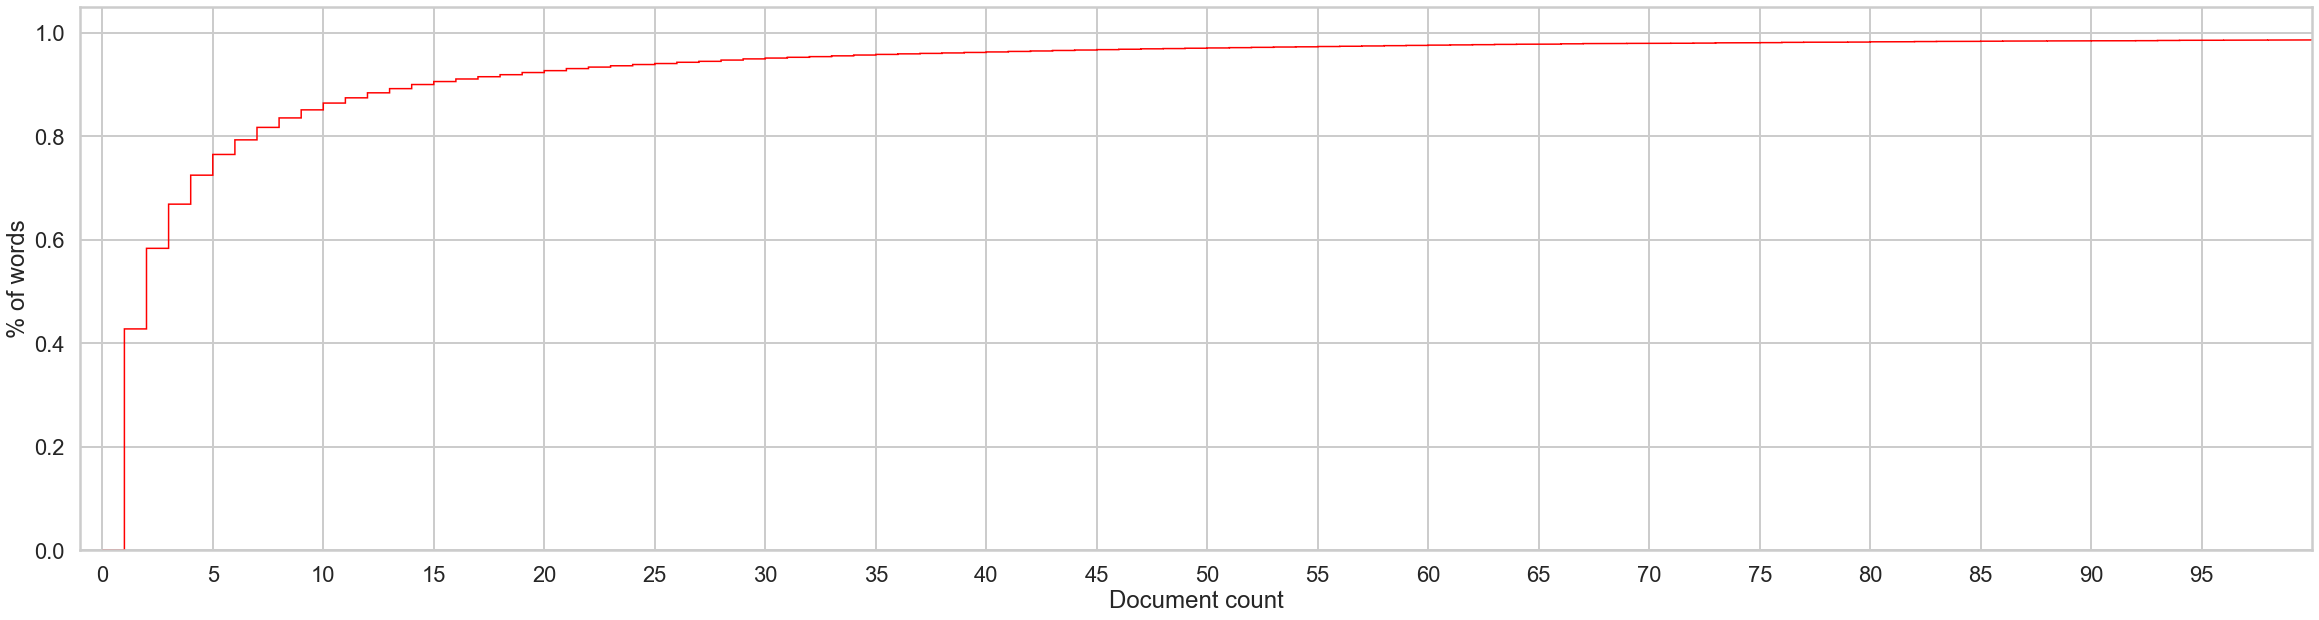

In [96]:
df = list(sorted((X > 0).sum(axis=0).reshape(-1).tolist()[0]))
c = pd.Series(df)
y = np.arange(c.sum())
_ = plt.hist(c,y,density=1,histtype='step',color='r',cumulative=True,linewidth=1.5)
_ = plt.xlim(-1,100)
_ = plt.xlabel('Document count')
_ = plt.ylabel('% of words')
_ = plt.xticks(np.arange(0, 100, 5))
_ = plt.rcParams['figure.figsize'] = 40, 10
plt.show()

From the figure above, I would set the minimum and maximum document frequencies to be 1 and 30, respectively.

Next, we cross-validate over alpha, by setting up some custom functions to allow for different classifiers and accuracy criteria.

In [97]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed in as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

The training and test masks are set upfirst, and then the cross-validation procedure.

In [98]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>
    
Answer: The log likelihood score measures the accuracy of our model by assessing how likely we are to correctly assess both fresh and rotten ratings. We try to optimize for greatest accuracy across our classes.

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

Answer: The accuracy would decrease because our model would be underfit to the data. (At very low $\alpha$, we would have an overfit and unsmooth model)
    
<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

In [104]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = 1

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
accuracy=[]
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    # your turn
    clf = MultinomialNB(alpha=alpha)
    clf.fit(Xtrainthis, ytrainthis)
    score = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
    if score > maxscore:
        best_alpha = alpha
        maxscore = score
    accuracy.append(score)
accuracy_alpha = dict(zip(alphas,accuracy))
print(accuracy_alpha)

{0.1: -951.8436388774683, 1: -755.702031582146, 5: -1356.416664946697, 10: -1518.4676196641478, 50: -1454.793704604941}


In [105]:
print("alpha: {}".format(best_alpha))

alpha: 1


<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

Answer: The use of the best alpha did not change the training accuracy but did lower the testing accuracy. Our optimized classifier did not do any better. I think it is likely that this is due to the range of alphas we tested. We tested few values around the optimal region of 0.5-1.
</div>

In [113]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.928464
Accuracy on test data:     0.721998


In [94]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[2056 2170]
 [ 663 6003]]


## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [114]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
             perfect 0.97
             delight 0.96
         provocative 0.96
         brilliantly 0.95
              tender 0.95
         masterpiece 0.94
        entertaining 0.94
              superb 0.94
             working 0.94
           different 0.94
Bad words	     P(fresh | word)
          repetitive 0.13
         forgettable 0.12
                thin 0.12
             unfunny 0.11
             leaving 0.11
                lame 0.11
                dull 0.11
          uninspired 0.11
               bland 0.08
       unfortunately 0.05


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

    Answer: A fascinating tool to use! Search queries / document similarity can be calcualated via the cosine similarity of vectors. Essentially, what we do above is to compute the similarity of each individual word to the trained model. High values are suggestive of fresh class, and low of the rotten class.
</div>



The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [125]:
# First make the prediction model
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0] # keep just the first column of probabilities (of rotten)
predict = clf.predict(x) # then make prediction for each

# But keep the mispredicted (sort by probability first)
bad_rotten = np.argsort(prob[y == 0])[:5] # for rotten rows, keep the first five rows where they thought fresh
bad_fresh = np.argsort(prob[y == 1])[-5:] # for fresh rows, keep the last five rows where they thought rotten

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
It survives today only as an unusually pure example of a typical 50s art-film strategy: the attempt to make the most modern and most popular of art forms acceptable to the intelligentsia by forcing it into an arcane, antique mold.

Working from an Elmore Leonard novel, Tarantino has created a gangster fiction that is never larger than life and sometimes smaller.

Walt Disney started by making movies in which animated drawings played the parts of people or animals who stood for people. Later he turned to making movies in which people or animals play the parts of animated drawings.

Lee is a long way from the size and scope of his best film, Do the Right Thing, but at least he is working on a subject he cares about and is doing it with polish.

Cast of newcomers is appealing, but this small-town melodrama is so old-fashioned and out-of-touch with contemporary youth that it feels as if it were made the same time that its story is set

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
Answer: we took a test query and the model predicted it incorrectly. The bag-of-words model we used did not take into account the important negation in the review.
    
</div>
</div>



In [127]:
#your turn

Xquery = vectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])
clf.predict_proba(Xquery)


array([[0.00132331, 0.99867669]])

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [137]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)


<div class="span5 alert alert-info">
<h3>Further steps</h3>

<b>Exercise:</b> Try at least one of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result. 

Answer: Naive Bayes n-grams. I used the inbuilt n-gram keyword in the Vectorizer to make n-grams up to a range of 5, then submitted these models to our fitting procedure. The test accuracy trended slightly down as n-gram size increased, probably reflective of the relatively sparse matrices we were attempting to fit (overfitting becomes an issue here).

Answer 2: Random forests n-grams. I tried a new approach, random forests, with n-grams up to 4. Test accuracy did not change for different sized n-grams in random forests. Interesting. Stayed at around .68 throughout. Overfitting, again.

Answer 3: tf-idf weighting. This model performed the worst on our test data, going to essentially guessing the majority class the entire time (~63%).
    
</div>

In [130]:
# N-grams using Naive Bayes

n_grams = list(range(1,5))
mlb = MultinomialNB(alpha=best_alpha)
trainScore = []
testScore = []
for i in n_grams:
    vect = CountVectorizer(min_df=best_min_df,ngram_range=(1,i))
    X,y = make_xy(critics,vectorizer=vect)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    mlb.fit(X_train,y_train)
    trainScore.append(mlb.score(X_train,y_train))
    testScore.append(mlb.score(X_test,y_test))
accuracy_list = dict(zip(testScore,n_grams))
print(accuracy_list)

{0.7716855857785393: 1, 0.7712572285285928: 2, 0.7586206896551724: 3, 0.7543371171557078: 4}


In [148]:
# Random forests with n-grams
from sklearn.ensemble import RandomForestClassifier
n_grams = list(range(1,5))
results = pd.DataFrame()
temp = []
for i in n_grams:
#    print("running loop{}".format(str(i)))
    rf = RandomForestClassifier()
    vect = CountVectorizer(min_df=best_min_df,ngram_range=(1,i))
    X,y = make_xy(critics,vectorizer=vect)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    rf.fit(X_train,y_train)
    temp.append(rf.score(X_test,y_test))
accuracy_rf = dict(zip(n_grams,temp))
print(accuracy_rf)

running loop1


/Users/jonathangerber/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


running loop2


/Users/jonathangerber/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


running loop3


/Users/jonathangerber/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


running loop4


/Users/jonathangerber/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{1: 0.6845148854144356, 2: 0.6860141357892482, 3: 0.6838723495395159, 4: 0.6843007067894624}


In [144]:
# Using tf-idf with n-grams

from sklearn.feature_extraction.text import TfidfVectorizer

n_grams = list(range(1,5))
mlb = MultinomialNB(alpha=best_alpha)
trainScore = []
testScore = []
for i in n_grams:
    tfidfvectorizer = TfidfVectorizer(min_df=best_min_df, stop_words='english', ngram_range=(1,i))
    Xtfidf=tfidfvectorizer.fit_transform(critics.quote)
    X,y = make_xy(critics,vectorizer=vect)
    X_train, X_test, y_train, y_test = train_test_split(Xtfidf, y, test_size=0.3)
    mlb.fit(X_train,y_train)
    trainScore.append(mlb.score(X_train,y_train))
    testScore.append(mlb.score(X_test,y_test))
accuracy_list = dict(zip(n_grams, testScore))
print(accuracy_list)


{1: 0.7155707860355537, 2: 0.6727350610409081, 3: 0.6348254444206468, 4: 0.6401799100449775}


In [ ]:
Xtfidf.shape